In [3]:
# Implementation of doc2vec on the IMDB 5000 dataset

In [95]:
from __future__ import absolute_import, division, print_function
import multiprocessing, os, pprint, re
import nltk
import gensim.models.word2vec as word2vec
import gensim.models.doc2vec as doc2vec
import sklearn.manifold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re, string

In [96]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('movie_metadata.csv')

In [97]:
df = df.drop(df.movie_imdb_link.name, 1)
def trim_and_remove_spaces(raw):
    if pd.isnull(raw) == False:
        return raw.strip().replace(' ', '_')

df.director_name = df.director_name.apply(trim_and_remove_spaces)
df.actor_2_name = df.actor_2_name.apply(trim_and_remove_spaces)

df.actor_1_name = df.actor_1_name.apply(trim_and_remove_spaces)
df.movie_title = df.movie_title.apply(trim_and_remove_spaces)
df.actor_3_name = df.actor_3_name.apply(trim_and_remove_spaces)
df.language = df.language.apply(trim_and_remove_spaces)
df.country = df.country.apply(trim_and_remove_spaces)

In [98]:
def descretize3(df, col):
    
    if(df[col].dtype == np.float64 or df[col].dtype == np.int64):
        df[col] = pd.qcut(df[col], 3, labels=['low', 'medium', 'high'], retbins=False)
        df[col] = df[col].apply(lambda x : (str(x)).replace(" ", ""))
        
def descretize2(df, col):
    
    if(df[col].dtype == np.float64 or df[col].dtype == np.int64):
        df[col] = pd.qcut(df[col], 2, labels=['low', 'high'], retbins=False)
        df[col] = df[col].apply(lambda x : (str(x)).replace(" ", ""))
        
def descretize10(df, col):
    
    if(df[col].dtype == np.float64 or df[col].dtype == np.int64):
        df[col] = pd.qcut(df[col], 3, labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], retbins=False)
        df[col] = df[col].apply(lambda x : (str(x)).replace(" ", ""))

descretize3(df, df.director_facebook_likes.name)
descretize3(df, df.num_critic_for_reviews.name)
descretize3(df, df.duration.name)
descretize3(df, df.actor_3_facebook_likes.name)
descretize3(df, df.actor_1_facebook_likes.name)

descretize3(df, df.gross.name)
descretize3(df, df.num_voted_users.name)
descretize3(df, df.cast_total_facebook_likes.name)
descretize3(df, df.num_user_for_reviews.name)
descretize3(df, df.budget.name)

descretize3(df, df.actor_2_facebook_likes.name)
descretize3(df, df.imdb_score.name)
descretize2(df, df.facenumber_in_poster.name)
descretize3(df, df.title_year.name)
descretize3(df, df.aspect_ratio.name)
descretize2(df, df.movie_facebook_likes.name)

In [99]:
from sklearn.utils import shuffle
df = shuffle(df)
df

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
1255,Color,Anne_Fletcher,medium,low,medium,low,Tom_Virtue,low,medium,Comedy|Drama,Miriam_Margolyes,The_Guilt_Trip,medium,low,Julene_Renee,low,cross country|love|mother son relationship|on ...,medium,English,USA,PG-13,high,high,low,low,medium,low
3579,Color,None,low,low,NaN,low,Fortunato_Cerlino,low,NaN,Crime|Drama|Thriller,Maria_Pia_Calzone,Gomorrah,low,low,Marco_D'Amore,high,NaN,low,Italian,Italy,TV-MA,NaN,NaN,low,high,low,low
1595,Black and White,Rawson_Marshall_Thurber,high,low,medium,high,Stephen_Root,medium,high,Comedy|Sport,Gary_Cole,Dodgeball:_A_True_Underdog_Story,high,medium,Joel_David_Moore,low,dodgeball|gym|las vegas|pirate|ups,high,English,USA,PG-13,medium,medium,high,medium,medium,low
2722,Color,Rodman_Flender,low,low,low,high,Fred_Willard,medium,low,Comedy|Fantasy|Horror|Thriller,Vivica_A._Fox,Idle_Hands,medium,medium,Elden_Henson,low,breasts|female frontal nudity|nude woman murde...,medium,English,USA,R,medium,low,medium,medium,low,low
1341,Color,Jonathan_Lynn,low,low,medium,medium,Phil_Hartman,low,medium,Comedy,Austin_Pendleton,Sgt._Bilko,medium,medium,Max_Casella,high,greenland|military|revenge|soldier|u.s. soldier,low,English,USA,PG,high,low,medium,low,medium,high
5031,Color,Thomas_L._Phillips,low,low,medium,low,Joe_Coffey,medium,NaN,Comedy|Horror|Thriller,Julianna_Pitt,Sanctuary;_Quite_a_Conundrum,low,low,John_Lucas,NaN,nudity|party|pirate|swimsuit|three word title,low,English,USA,NaN,low,high,low,low,high,high
3724,Color,Robert_Duvall,medium,high,high,low,Todd_Allen,low,medium,Drama,John_Beasley,The_Apostle,low,low,June_Carter_Cash,low,church|louisiana|minister|preacher|texas,medium,English,USA,PG-13,low,low,low,high,low,high
6,Color,Sam_Raimi,high,high,low,high,James_Franco,high,high,Action|Adventure|Romance,J.K._Simmons,Spider-Man_3,high,high,Kirsten_Dunst,low,sandman|spider man|symbiote|venom|villain,high,English,USA,PG-13,high,medium,high,medium,medium,low
2600,Color,Martin_Brest,medium,medium,medium,medium,Ronny_Cox,medium,high,Action|Comedy|Crime,Judge_Reinhold,Beverly_Hills_Cop,high,medium,James_Russo,low,drug dealer|drugs|murder|police brutality|poli...,medium,English,USA,R,medium,low,medium,high,low,low
4445,Color,Timothy_Woodward_Jr.,low,low,high,medium,Johnny_Messner,medium,NaN,Action|Crime|Thriller,Katrina_Law,Checkmate,low,medium,Michael_Paré,high,NaN,low,English,USA,NaN,low,high,medium,low,medium,high


In [100]:
input = []
for a in df.iterrows():
    words1 = []
    label1 = []
    
    for b in a[1].iteritems():
        if(b[0] == 'movie_title'):
            label1.append(str(b[1]))
            #words1.append(str(b[0]))
            #words1.append(str(b[1]))
        elif b[0] == 'genres':
            for g in str(b[1]).split("|"):
                words1.append('genre')
                words1.append(trim_and_remove_spaces(g.lower()))
        elif b[0] == 'plot_keywords':
            for p in str(b[1]).split("|"):
                words1.append('plot')
                words1.append(trim_and_remove_spaces(p.lower()))
        elif b[0] in ['director_name', 'actor_2_name', 'actor_1_name', 'actor_3_name']:
            words1.append(str(b[0]))
            words1.append(str(b[1]))
        else:
            words1.append(str(b[0]) + "_" + str(b[1]))
    input.append(doc2vec.LabeledSentence(words=words1, tags=label1))

In [101]:
input

[LabeledSentence(words=['color_Color', 'director_name', 'Anne_Fletcher', 'num_critic_for_reviews_medium', 'duration_low', 'director_facebook_likes_medium', 'actor_3_facebook_likes_low', 'actor_2_name', 'Tom_Virtue', 'actor_1_facebook_likes_low', 'gross_medium', 'genre', 'comedy', 'genre', 'drama', 'actor_1_name', 'Miriam_Margolyes', 'num_voted_users_medium', 'cast_total_facebook_likes_low', 'actor_3_name', 'Julene_Renee', 'facenumber_in_poster_low', 'plot', 'cross_country', 'plot', 'love', 'plot', 'mother_son_relationship', 'plot', 'on_the_road', 'plot', 'trip', 'num_user_for_reviews_medium', 'language_English', 'country_USA', 'content_rating_PG-13', 'budget_high', 'title_year_high', 'actor_2_facebook_likes_low', 'imdb_score_low', 'aspect_ratio_medium', 'movie_facebook_likes_low'], tags=['The_Guilt_Trip']),
 LabeledSentence(words=['color_Color', 'director_name', 'None', 'num_critic_for_reviews_low', 'duration_low', 'director_facebook_likes_nan', 'actor_3_facebook_likes_low', 'actor_2_n

In [102]:
model = doc2vec.Doc2Vec(
    dm=1, # distributed memory
    alpha=0.025,
    min_alpha=0.025,
    min_count = 0,
    workers = multiprocessing.cpu_count(),
    iter=10,
    size=200,
    window=50
)  # use fixed learning rate
model.build_vocab(input)
for epoch in range(10):
    model.train(input)
    model.alpha -= 0.002  # decrease the learning rate
    model.min_alpha = model.alpha  # fix the learning rate, no decay

In [105]:
(model.wv.vocab)

{'Peter_Jacobson': <gensim.models.keyedvectors.Vocab at 0x118ea7eb8>,
 'rustler': <gensim.models.keyedvectors.Vocab at 0x124995d30>,
 'newlywed': <gensim.models.keyedvectors.Vocab at 0x124995ac8>,
 'green_beret': <gensim.models.keyedvectors.Vocab at 0x124995748>,
 'woman_kills_attacker': <gensim.models.keyedvectors.Vocab at 0x124995588>,
 'Antoni_Corone': <gensim.models.keyedvectors.Vocab at 0x124995b38>,
 'battle_of_gallipoli': <gensim.models.keyedvectors.Vocab at 0x1249959b0>,
 'inchon': <gensim.models.keyedvectors.Vocab at 0x124995f28>,
 'declaration_of_independence': <gensim.models.keyedvectors.Vocab at 0x124995a90>,
 'outrage': <gensim.models.keyedvectors.Vocab at 0x128f5bc88>,
 'Maury_Chaykin': <gensim.models.keyedvectors.Vocab at 0x124995ba8>,
 'Dylan_Kussman': <gensim.models.keyedvectors.Vocab at 0x124995da0>,
 'wrong_address': <gensim.models.keyedvectors.Vocab at 0x1245192b0>,
 'character_name_in_title': <gensim.models.keyedvectors.Vocab at 0x124995f98>,
 '13_year_olds': <gens

Populating the interactive namespace from numpy and matplotlib


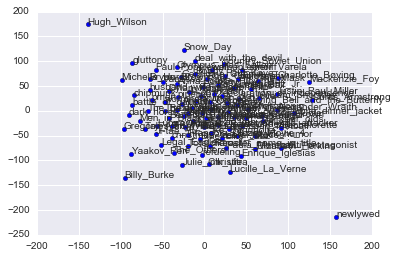

In [73]:
%pylab inline
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(model.wv.syn0[:100,:])
vocabulary = model.wv.vocab.keys()
plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(vocabulary, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()


In [133]:
model.docvecs.most_similar([model['superhero'], model['cast_total_facebook_likes_low']])


[('Dredd', 0.2909585237503052),
 ('Space:_Above_and_Beyond', 0.2893359661102295),
 ('Battlefield_Earth', 0.27753084897994995),
 ('Grown_Ups', 0.2744165360927582),
 ('Confessions_of_a_Dangerous_Mind', 0.2705983519554138),
 ('Master_and_Commander:_The_Far_Side_of_the_World', 0.27035826444625854),
 ('Apollo_18', 0.268036425113678),
 ('Rush_Hour_3', 0.2609756290912628),
 ('Somewhere', 0.25988447666168213),
 ('Drillbit_Taylor', 0.2559008002281189)]